## Phân tích trường hợp toàn vẹn (CCA)

Phân tích trường hợp toàn vẹn (CCA), còn được gọi là trường hợp "xóa list-wise" gồm việc **loại bỏ** các quan sát có các giá trị bị khuyết trong **bất kỳ** biến nào. CCA chỉ phân tích những quan sát có thông tin về **tất cả** các biến trong tập dữ liệu.

### Những biến nào cần gán với CCA?

CCA có thể áp dụng với cả biến dạng số và biến hạng mục.


### Các giả định

 CCA hoạt động tốt khi dữ liệu bị khuyết hoàn toàn ngẫu nhiên (MCAR). Trên thực tế, chúng ta nên sử dụng CCA nếu có lý do tin rằng dữ liệu bị khuyết một cách ngẫu nhiên, chứ không phải các trường hợp khác. Khi dữ liệu là MCAR, việc loại trừ các quan sát có thông tin bị khuyết về bản chất cũng giống như việc loại trừ ngẫu nhiên một số quan sát khỏi tập dữ liệu. Do đó, tập dữ liệu sau CCA là đại diện hợp lý cho tập dữ liệu gốc.



### Ưu điểm

- Dễ thực hiện.
- Không cần thao tác dữ liệu.
- Duy trì phân phối biến (nếu dữ liệu là MCAR thì phân phối các biến của tập dữ liệu đã rút gọn phải khớp với phân phối trong tập dữ liệu gốc).

### Khuyết điểm

- Nó có thể loại trừ phần lớn tập dữ liệu ban đầu (nếu dữ liệu bị khuyết vẫn còn nhiều).
- Các quan sát bị loại trừ có thể cung cấp thông tin cho phân tích (nếu dữ liệu không bị khuyết ngẫu nhiên).
- CCA sẽ tạo tập dữ liệu bị chệch nếu các trường hợp toàn vẹn khác với dữ liệu ban đầu (ví dụ: khi thông tin bị khuyết trên thực tế là MAR hoặc NMAR và không bị khuyết ngẫu nhiên).
- Khi đưa các mô hình vào sản xuất, mô hình sẽ không biết cách xử lý dữ liệu bị khuyết.

### Khi nào sử dụng CCA?

- Dữ liệu bị khuyết hoàn toàn ngẫu nhiên.
- Không quá 5% tổng số tập dữ liệu chứa dữ liệu bị khuyết.

Trong thực tế, CCA là một phương pháp được chấp nhận khi lượng thông tin bị khuyết nhỏ. Thật không may, không có quy tắc chung nào để xác định lượng dữ liệu bị khuyết là nhỏ hay không đáng kể. Tuy nhiên, theo hướng dẫn chung, CCA là một lựa chọn khả thi nếu tổng lượng dữ liệu bị khuyết ~ 5%  hoặc ít hơn so với tập dữ liệu gốc.

Trong nhiều tập dữ liệu thực, lượng dữ liệu bị khuyết không bao giờ nhỏ nên CCA thường không được chọn.

### CCA và mô hình trong sản xuất

Khi sử dụng CCA, chúng ta loại bỏ tất cả các quan sát có chứa thông tin bị khuyết. Tuy nhiên, dữ liệu mà chúng ta muốn cho điểm với mô hình có thể thực sự chứa thông tin bị khuyết. Điều này đặt ra vấn đề khi sử dụng mô hình trong các hệ thống trực tiếp, hay khi gọi và đưa các mô hình vào sản xuất: khi một quan sát chứa dữ liệu bị khuyết, mô hình sẽ không thể xử lý được.

Để tránh vấn đề này, khi đưa các mô hình vào sản xuất, chúng ta cần thực hiện 1 trong 2 điều: không cho điểm các quan sát với dữ liệu bị khuyết hoặc thay thế các giá trị bị khuyết bằng một số khác. Chúng ta có thể chọn bất kỳ kỹ thuật nào trong số các kỹ thuật gán sẽ được thảo luận trong các bài giảng sau để thay thế NA trong dữ liệu được tính điểm. 

## Trong bản mô phỏng này:

Chúng ta sẽ sử dụng tập dữ liệu giá nhà để chứng minh cách thực hiện CCA.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# hiển thị tất cả các cột của dataframe trong notebook
pd.set_option('display.max_columns', None)

In [2]:
# hãy load tập dữ liệu House Prices
# và khám phá các shape (hàng và cột)

data = pd.read_csv('../dataset/houseprice.csv')
data.shape

(1460, 81)

In [3]:
# trực quan hóa tập dữ liệu
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
## Yêu cầu 1: tìm các biến có quan sát bị khuyết 
## VIẾT CODE Ở ĐÂY:
vars_with_na = [var for var in data.columns if data[var].isnull().mean() > 0]
vars_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

<details><summary> Gợi ý </summary>

[isnull()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)

</details>

In [14]:
## Yêu cầu 2: tìm xem chúng là biến dạng số hay biến hạng mục 
## VIẾT CODE Ở ĐÂY:
for var in vars_with_na:
    print(var, ":", data[var].dtype)

LotFrontage : float64
Alley : object
MasVnrType : object
MasVnrArea : float64
BsmtQual : object
BsmtCond : object
BsmtExposure : object
BsmtFinType1 : object
BsmtFinType2 : object
Electrical : object
FireplaceQu : object
GarageType : object
GarageYrBlt : float64
GarageFinish : object
GarageQual : object
GarageCond : object
PoolQC : object
Fence : object
MiscFeature : object


<details><summary> Gợi ý </summary>

[dtypes()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html)

</details>

Có cả biến dạng số và biến hạng mục có các quan sát bị khuyết. Chúng ta thấy từ kiểu biến có một số là float và một số là object.

In [15]:
# xem các giá trị của các biến với
# dữ liệu bị khuyết

data[vars_with_na].head(10)

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,NaN,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
5,85.0,NaN,NaN,0.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,1993.0,Unf,TA,TA,NaN,MnPrv,Shed
6,75.0,NaN,Stone,186.0,Ex,TA,Av,GLQ,Unf,SBrkr,Gd,Attchd,2004.0,RFn,TA,TA,NaN,NaN,NaN
7,NaN,NaN,Stone,240.0,Gd,TA,Mn,ALQ,BLQ,SBrkr,TA,Attchd,1973.0,RFn,TA,TA,NaN,NaN,Shed
8,51.0,NaN,NaN,0.0,TA,TA,No,Unf,Unf,FuseF,TA,Detchd,1931.0,Unf,Fa,TA,NaN,NaN,NaN
9,50.0,NaN,NaN,0.0,TA,TA,No,GLQ,Unf,SBrkr,TA,Attchd,1939.0,RFn,Gd,TA,NaN,NaN,NaN


In [17]:
## Yêu cầu 3: hãy tìm phần trăm các quan sát bị khuyết trên mỗi biến 
# tính phần trăm bị khuyết (như đã thực hiện ở phần 3)
# sử dụng phương thức isnull() và mean() từ pandas
data_na = data[vars_with_na].isnull().mean()

# biến đổi mảng thành dataframe
data_na = pd.DataFrame(data_na.reset_index())

# thêm tên cột vào dataframe
data_na.columns = ['variable', 'na_percentage']

# sắp xếp dataframe theo phần trăm NA trên mỗi biến
data_na = data_na.sort_values(by='na_percentage', ascending=False)

# hiển thị
data_na


,variable,na_percentage
16,PoolQC,0.995205
18,MiscFeature,0.963014
1,Alley,0.937671
17,Fence,0.807534
2,MasVnrType,0.597260
10,FireplaceQu,0.472603
0,LotFrontage,0.177397
11,GarageType,0.055479
12,GarageYrBlt,0.055479
13,GarageFinish,0.055479


<details><summary> Gợi ý </summary>

[sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)

</details>

6 biến đầu tiên chứa nhiều thông tin bị khuyết, do đó, chúng ta không thể sử dụng CCA nếu xem xét các biến đó, vì hầu hết các quan sát trong tập dữ liệu sẽ bị loại bỏ. Hoặc chúng ta có thể sử dụng CCA nếu bỏ qua việc sử dụng các biến có nhiều NA.

Đối với bản mô phỏng này, tôi sẽ bỏ qua 6 biến đầu tiên có nhiều dữ liệu bị khuyết và tiến hành CCA trong phần còn lại của tập dữ liệu.

In [18]:
## Yêu cầu 4: thu thập các biến không có hoặc ít hơn 5% NA
vars_cca = [var for var in data.columns if data[var].isnull().mean() <= 0.05]
vars_cca

['Id',
 'MSSubClass',
 'MSZoning',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SaleP

In [19]:
## Yêu cầu 5: tính phần trăm các quan sát với 
# trường hợp toàn vẹn: chẳng hạn, với các giá trị cho tất cả các biến

# phương thức dropna(), loại bỏ các quan sát chứa
# na ở bất kỳ hàng/cột nào
complete_cases_percentage = len(data[vars_cca].dropna()) / len(data)
complete_cases_percentage

0.9671232876712329

<details><summary> Gợi ý </summary>

[dropna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

</details>

In [21]:
## Yêu cầu 6: tạo tập dữ liệu trường hợp toàn vẹn
# nói cách khác, loại bỏ các quan sát với na trong bất kỳ biến nào

## VIẾT CODE Ở ĐÂY:
data_cca = data[vars_cca].dropna()
data.shape, data_cca.shape

((1460, 81), (1412, 69))

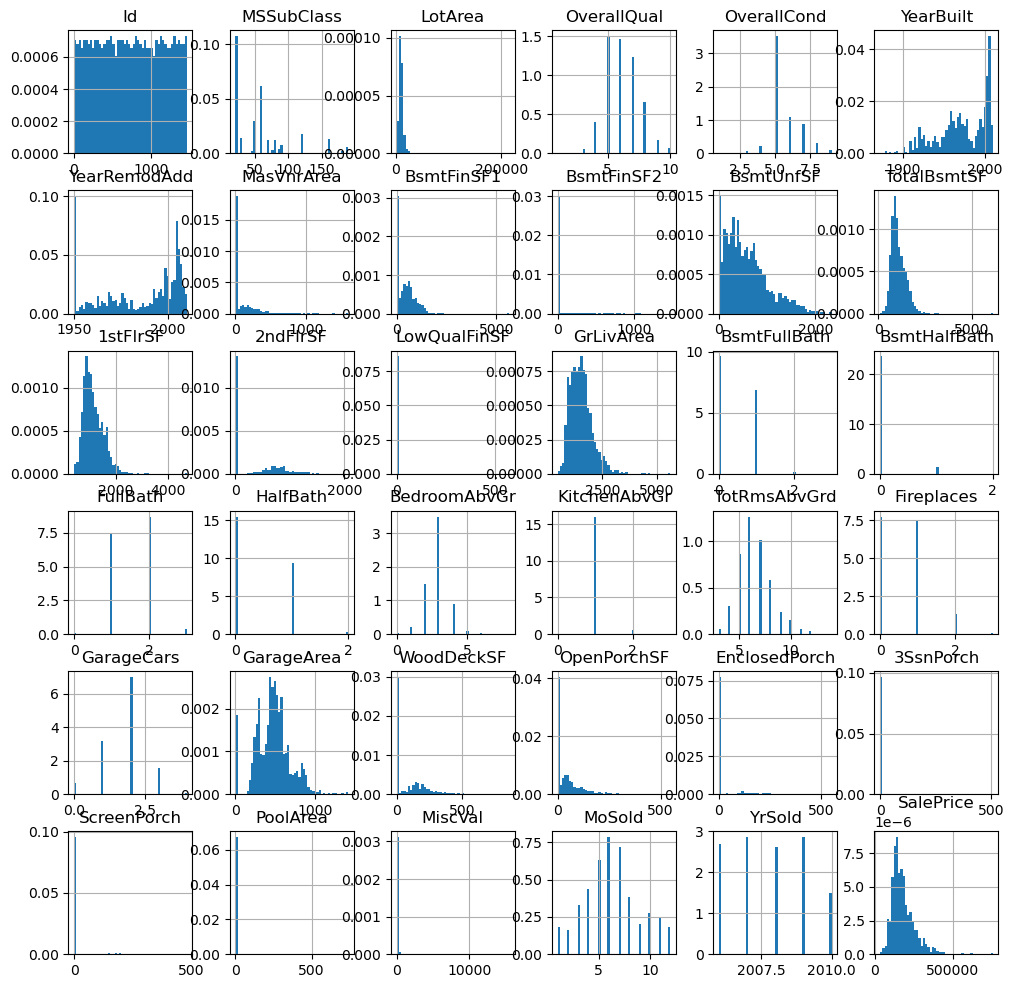

In [22]:
# vẽ biểu đồ tần suất cho tất cả các biến số trong
# tập dữ liệu trường hợp toàn vẹn (như đã làm trong phần 3)

data_cca.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

<Axes: >

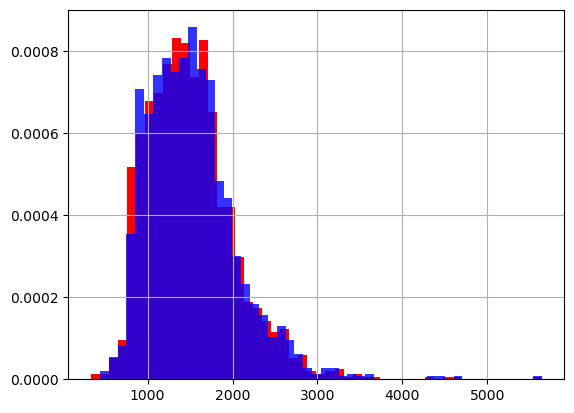

In [23]:
## kiểm tra phân phối của một số biến trước và sau khi
# cca: biểu đồ tần suất 

fig = plt.figure()
ax = fig.add_subplot(111)

# dữ liệu gốc
data['GrLivArea'].hist(bins=50, ax=ax, density=True, color='red')

# dữ liệu sau cca, đối số alpha khiến màu trong suốt, nên chúng ta có thể
# thấy lớp phủ của 2 phân phối
data_cca['GrLivArea'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

<Axes: ylabel='Density'>

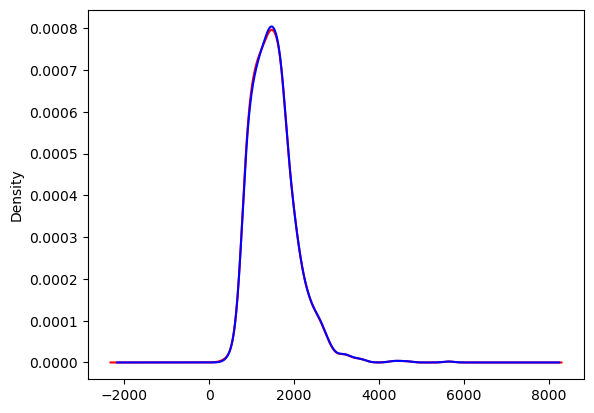

In [24]:
## kiểm tra phân phối của một số biến trước và sau khi
# cca: biểu đồ mật độ

fig = plt.figure()
ax = fig.add_subplot(111)

# dữ liệu gốc
data['GrLivArea'].plot.density(color='red')

# dữ liệu sau cca
data_cca['GrLivArea'].plot.density(color='blue')

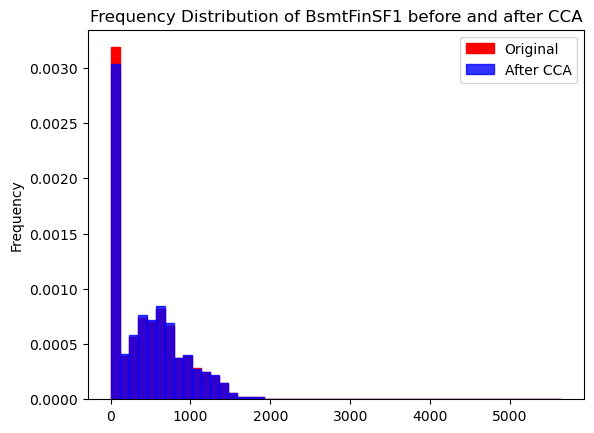

In [26]:
## Yêu cầu 7: kiểm tra phân phối của một số biến trước và sau khi
# cca: biểu đồ tần suất 

fig = plt.figure()
ax = fig.add_subplot(111)

# dữ liệu gốc
data['BsmtFinSF1'].plot(kind='hist', bins=50, edgecolor='red', density=True, color='red', ax=ax)

# dữ liệu sau cca, đối số alpha khiến màu trong suốt, nên chúng ta có thể
# thấy lớp phủ của 2 phân phối
data_cca['BsmtFinSF1'].plot(kind='hist', bins=50, edgecolor='blue', density=True, color='blue', alpha=0.8, ax=ax)

# thêm chú thích
plt.legend(labels=['Original', 'After CCA'])
plt.title('Frequency Distribution of BsmtFinSF1 before and after CCA')
plt.show()


<details><summary> Gợi ý </summary>

[hist()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html)

</details>

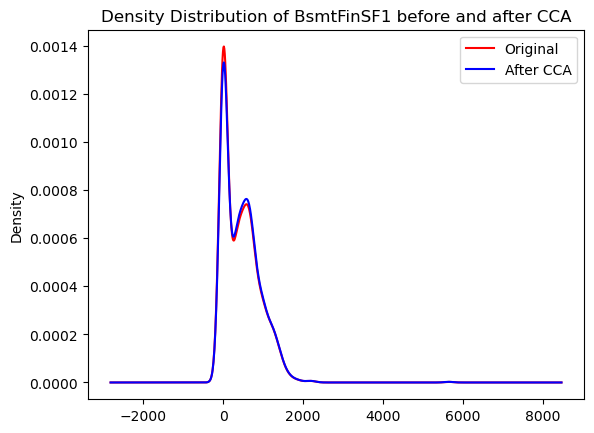

In [27]:
## Yêu cầu 8: kiểm tra phân phối của một số biến trước và sau khi 
# cca: biểu đồ mật độ

fig = plt.figure()
ax = fig.add_subplot(111)

# dữ liệu gốc
data['BsmtFinSF1'].plot(kind='density', color='red')

# dữ liệu sau cca
data_cca['BsmtFinSF1'].plot(kind='density', color='blue')

# thêm chú thích
plt.legend(labels=['Original', 'After CCA'])
plt.title('Density Distribution of BsmtFinSF1 before and after CCA')
plt.show()


<details><summary> Gợi ý </summary>

[plot.density()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html)

</details>

Từ các biểu đồ trên, phân phối của các biến dạng số được chọn trong tập dữ liệu gốc và trường hợp toàn vẹn rất giống nhau, đó là những gì chúng ta dự kiến từ CCA nếu dữ liệu bị khuyết ngẫu nhiên và chỉ chiếm một tỷ lệ nhỏ trong các quan sát.


Trong các cell tiếp theo, chúng ta sẽ khám phá phân phối của các biến hạng mục. Để thực hiện, chúng ta sẽ đánh giá tỷ lệ phần trăm quan sát hiển thị từng hạng mục duy nhất. 

In [28]:
# hàm sau thu thập phần trăm các quan sát
# cho từng hạng mục trong tập dữ liệu gốc và trường hợp toàn vẹn
# đặt trong cùng một dataframe mới


def categorical_distribution(df, df_cca, variable):
    tmp = pd.concat(
        [
            # phần trăm các quan sát trên mỗi hạng mục, dữ liệu gốc
            df[variable].value_counts() / len(df),

            # phần trăm các quan sát trên mỗi hạng mục, dữ liệu cca
            df_cca[variable].value_counts() / len(df_cca)
        ],
        axis=1)

    # thêm tên cột
    tmp.columns = ['original', 'cca']

    return tmp

In [30]:
cols = ['BsmtQual', 'MasVnrType', 'SaleCondition']

for col in cols:
    # Lấy các giá trị duy nhất và số lần xuất hiện của chúng
    value_counts = data[col].value_counts()

    # In kết quả
    print(f"Unique values and counts for {col}:\n{value_counts}\n")


Unique values and counts for BsmtQual:
BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64

Unique values and counts for MasVnrType:
MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

Unique values and counts for SaleCondition:
SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64



Từ đầu ra của các cell trên, phân phối của các ngôi nhà ở từng hạng mục trong tập dữ liệu gốc và trường hợp toàn vẹn rất giống nhau, như đã dự kiến nếu dữ liệu bị khuyết hoàn toàn ngẫu nhiên và tỷ lệ dữ liệu bị khuyết nhỏ.